<a href="https://colab.research.google.com/github/OdinProjectI/ODIN/blob/main/CasualtiesOfWarInAfghanistan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Casualties of War in Afghanistan**
1. Exploring Civilian Casualties
    - Fatalities by Area
    - Fatalities by Types (Civilian v.s Non-civilian)
    - Seasonal Fatalities
    - Fatalities (Civilian v.s Perpetrators)   
2. Northern Afghanistan
    - Perpetrators
    - Events
3. Forecasting Casualties
    - SARIMAX Model

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/SpecialForces_Badge.svg/1024px-SpecialForces_Badge.svg.png" width='500px' style="text-align:center">

In [1]:
import pandas as pd
import numpy as np
import warnings
import os

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from typing import List, Dict
warnings.filterwarnings('ignore')

In [3]:
afghan_df: 'DataFrame' = pd.read_csv(os.environ['DATASET'])
afghan_df['event_date'] = pd.to_datetime(afghan_df['event_date'])
afghan_df['is_civilian_fatality'] = afghan_df['civilian_targeting'].replace({'Civilian targeting': 1, np.nan:0}) # label civilian v.s non-civilian fatalities
afghan_df['incident_month'] = afghan_df['event_date'].apply(lambda row: row.month_name() )
months: List[str] = pd.Series(pd.date_range(start="2021-01-01", end="2021-12-01", freq='M')).apply(lambda row: row.month_name() ).tolist()

pd.options.display.max_columns = afghan_df.shape[1]

In [ ]:
afghan_df.head(5)

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,AFG66781,2023-07-13,2023,1,Political violence,Battles,Armed clash,Military Forces of Afghanistan (2021-),NaN,1,Military Forces of Afghanistan (2021-),NaN,1,11,NaN,4,Caucasus and Central Asia,Afghanistan,Nangarhar,Kama,NaN,Kama,34.4432,70.6565,2,Hasht-e Subh,National,"On 13 July 2023, a Taliban commander and the K...",0,NaN,1689690645
1,AFG66784,2023-07-13,2023,1,Political violence,Battles,Armed clash,Unidentified Armed Group (Afghanistan),NaN,3,TTP: Tehreek-i-Taliban Pakistan,NaN,2,23,NaN,4,Caucasus and Central Asia,Afghanistan,Paktika,Sharan,NaN,Sharan,33.1757,68.7304,1,Hasht-e Subh,National,"On 13 July 2023, one Tehreek-i-Taliban Pakista...",1,NaN,1689690645
2,AFG66796,2023-07-13,2023,2,Strategic developments,Strategic developments,Disrupted weapons use,Police Forces of Afghanistan (2021-),NaN,1,Unidentified Armed Group (Afghanistan),NaN,3,13,NaN,4,Caucasus and Central Asia,Afghanistan,Balkh,Mazar-e-Sharif,NaN,Mazar-e-Sharif,36.7090,67.1109,3,Afghan Islamic Press News Agency,National,"Weapons seizure: Around 13 July 2023, Taliban ...",0,NaN,1689690645
3,AFG66802,2023-07-12,2023,2,Strategic developments,Strategic developments,Other,Government of Afghanistan (2021-),NaN,1,Civilians (Afghanistan),Teachers (Afghanistan); Students (Afghanistan),7,17,NaN,4,Caucasus and Central Asia,Afghanistan,Kabul,Kabul,NaN,Kabul,34.5167,69.1833,1,Independent Persian; Twitter; Zawia News,New media-Subnational,"Other: Around 12 July 2023 (as reported), the ...",0,NaN,1689690645
4,AFG66803,2023-07-12,2023,1,Strategic developments,Strategic developments,Other,Unidentified Armed Group (Afghanistan),NaN,3,Civilians (Afghanistan),NaN,7,37,NaN,4,Caucasus and Central Asia,Afghanistan,Nangarhar,Deh Bala,NaN,Deh Bala,34.0923,70.4690,2,Afghan Islamic Press News Agency; Etilaat e Ro...,National-International,"Explosive remnants of war: On 12 July 2023, tw...",2,NaN,1689690645


## **Trends of Fatalities in Afghanistan**

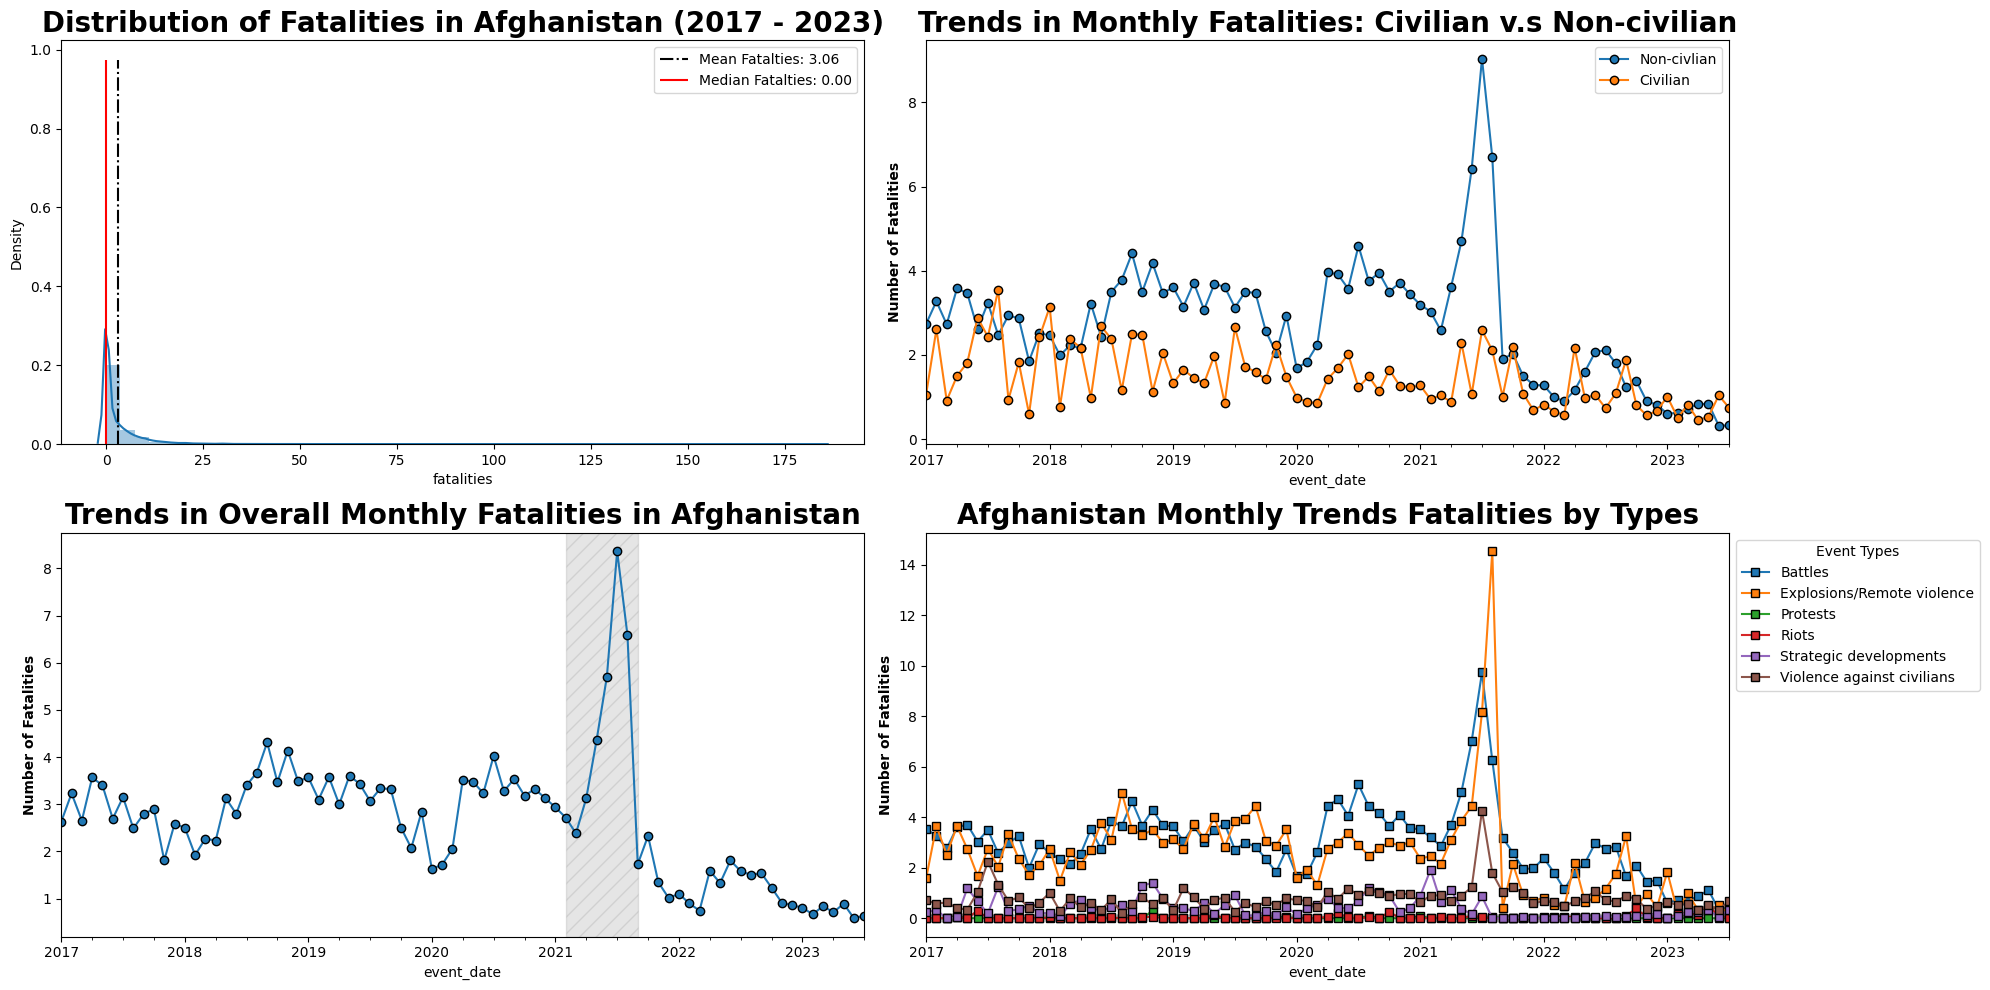

In [133]:
mean_fatalities: float = afghan_df['fatalities'].mean()
median_fatalities: float = afghan_df['fatalities'].median()

fig = plt.figure(figsize=(35,10))
ax = fig.add_subplot(2,2,1)
sns.distplot(afghan_df['fatalities'], ax=ax)
ax.set_title("Distribution of Fatalities in Afghanistan (2017 - 2023)", fontweight='bold', fontsize=20)

ax.vlines(mean_fatalities,
           ymin=0.0,
           ymax=0.975,
           label=f"Mean Fatalties: {mean_fatalities:.2f}",
           linestyle="-.",
           color='black')

ax.vlines(median_fatalities,
           ymin=0.0,
           ymax=0.975,
           label=f"Median Fatalties: {median_fatalities:.2f}",
           linestyle="solid",
           color='red')

ax.legend()

ax = fig.add_subplot(2,2,2)
afghan_df.groupby(['event_date', 'is_civilian_fatality'])['fatalities'].mean().unstack("is_civilian_fatality").replace({np.nan:0.0}).rename({0.0: 'Non-civlian', 1.0: 'Civilian'}, axis=1).resample('M').mean().plot(marker='o', mec='black', ax=ax)
ax.set_title("Trends in Monthly Fatalities: Civilian v.s Non-civilian", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

plt.legend()

ax = fig.add_subplot(2,2,3)
afghan_df.groupby('event_date')['fatalities'].mean().resample("M").mean().plot(ax=ax, marker='o', mec='black') # Jan 2021 - 2022

ax.axvspan(xmin=pd.to_datetime('2021-02-28 '), xmax=pd.to_datetime('2021-09-30'), alpha=0.2, color='grey' , hatch="//")
ax.set_title("Trends in Overall Monthly Fatalities in Afghanistan", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

ax = fig.add_subplot(2,2,4)
afghan_df.groupby(['event_date', 'event_type'])['fatalities'].mean().unstack("event_type").replace({np.nan:0.0}).resample("M").mean().plot(figsize=(20,10), marker='s', mec='black', ax=ax)
ax.set_title("Afghanistan Monthly Trends Fatalities by Types", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.legend(title="Event Types", bbox_to_anchor=(1,1))
plt.tight_layout()

## **Afghan Fatalities by Month and Province**

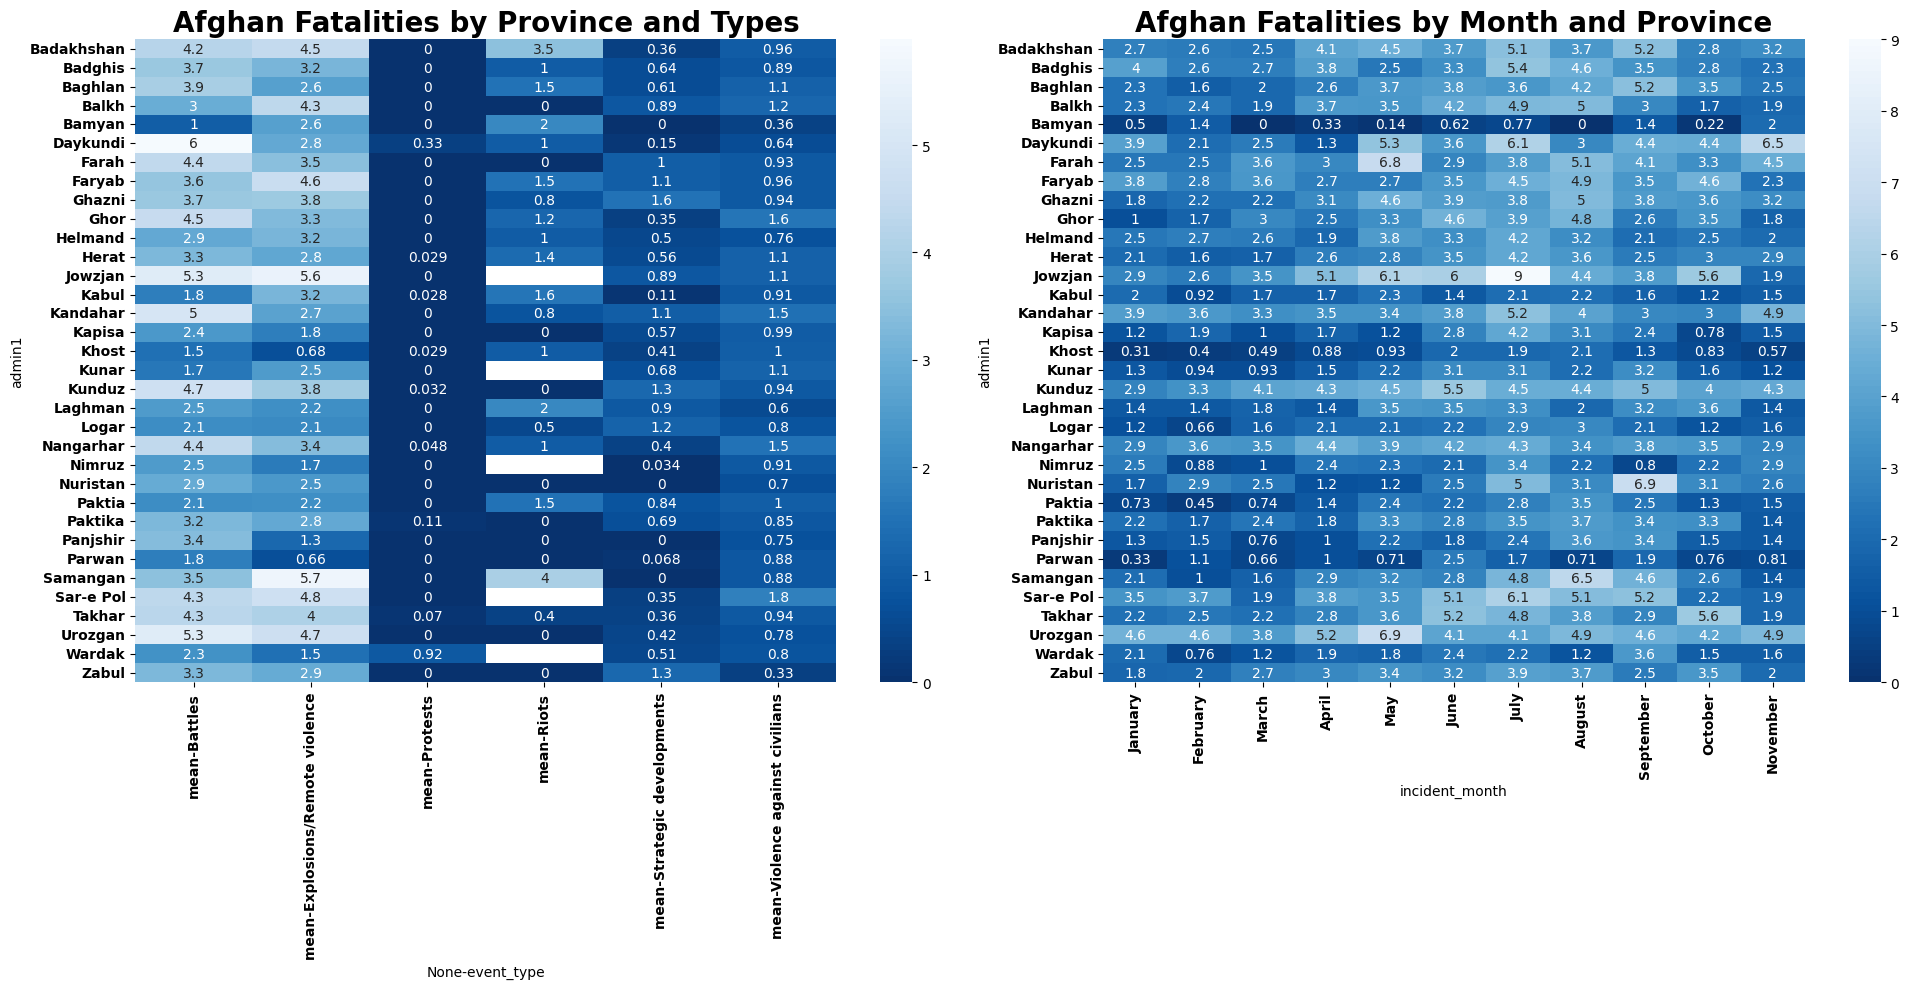

In [117]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1)
sns.heatmap(afghan_df.groupby(['event_type', 'admin1'])['fatalities'].agg(['mean']).unstack("event_type"),
            ax=ax,
            annot=True,
            cmap=ListedColormap(sns.color_palette(palette='Blues_r', n_colors=100)))

ax.set_title("Afghan Fatalities by Province and Types", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

ax = fig.add_subplot(1,2,2)
df: 'DataFrame' = pd.pivot_table(data=afghan_df, columns='incident_month', index=['admin1'], values='fatalities', aggfunc='mean').replace({np.nan: 0.0}).sort_values(by=afghan_df['admin1'].tolist(), axis=1, ascending=False)[months]
sns.heatmap(df,
            ax=ax,
            annot=True,
            cmap=ListedColormap(sns.color_palette(palette='Blues_r', n_colors=100)))

ax.set_title("Afghan Fatalities by Month and Province", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

plt.tight_layout()


## **Fatalities Seasonal Trend**

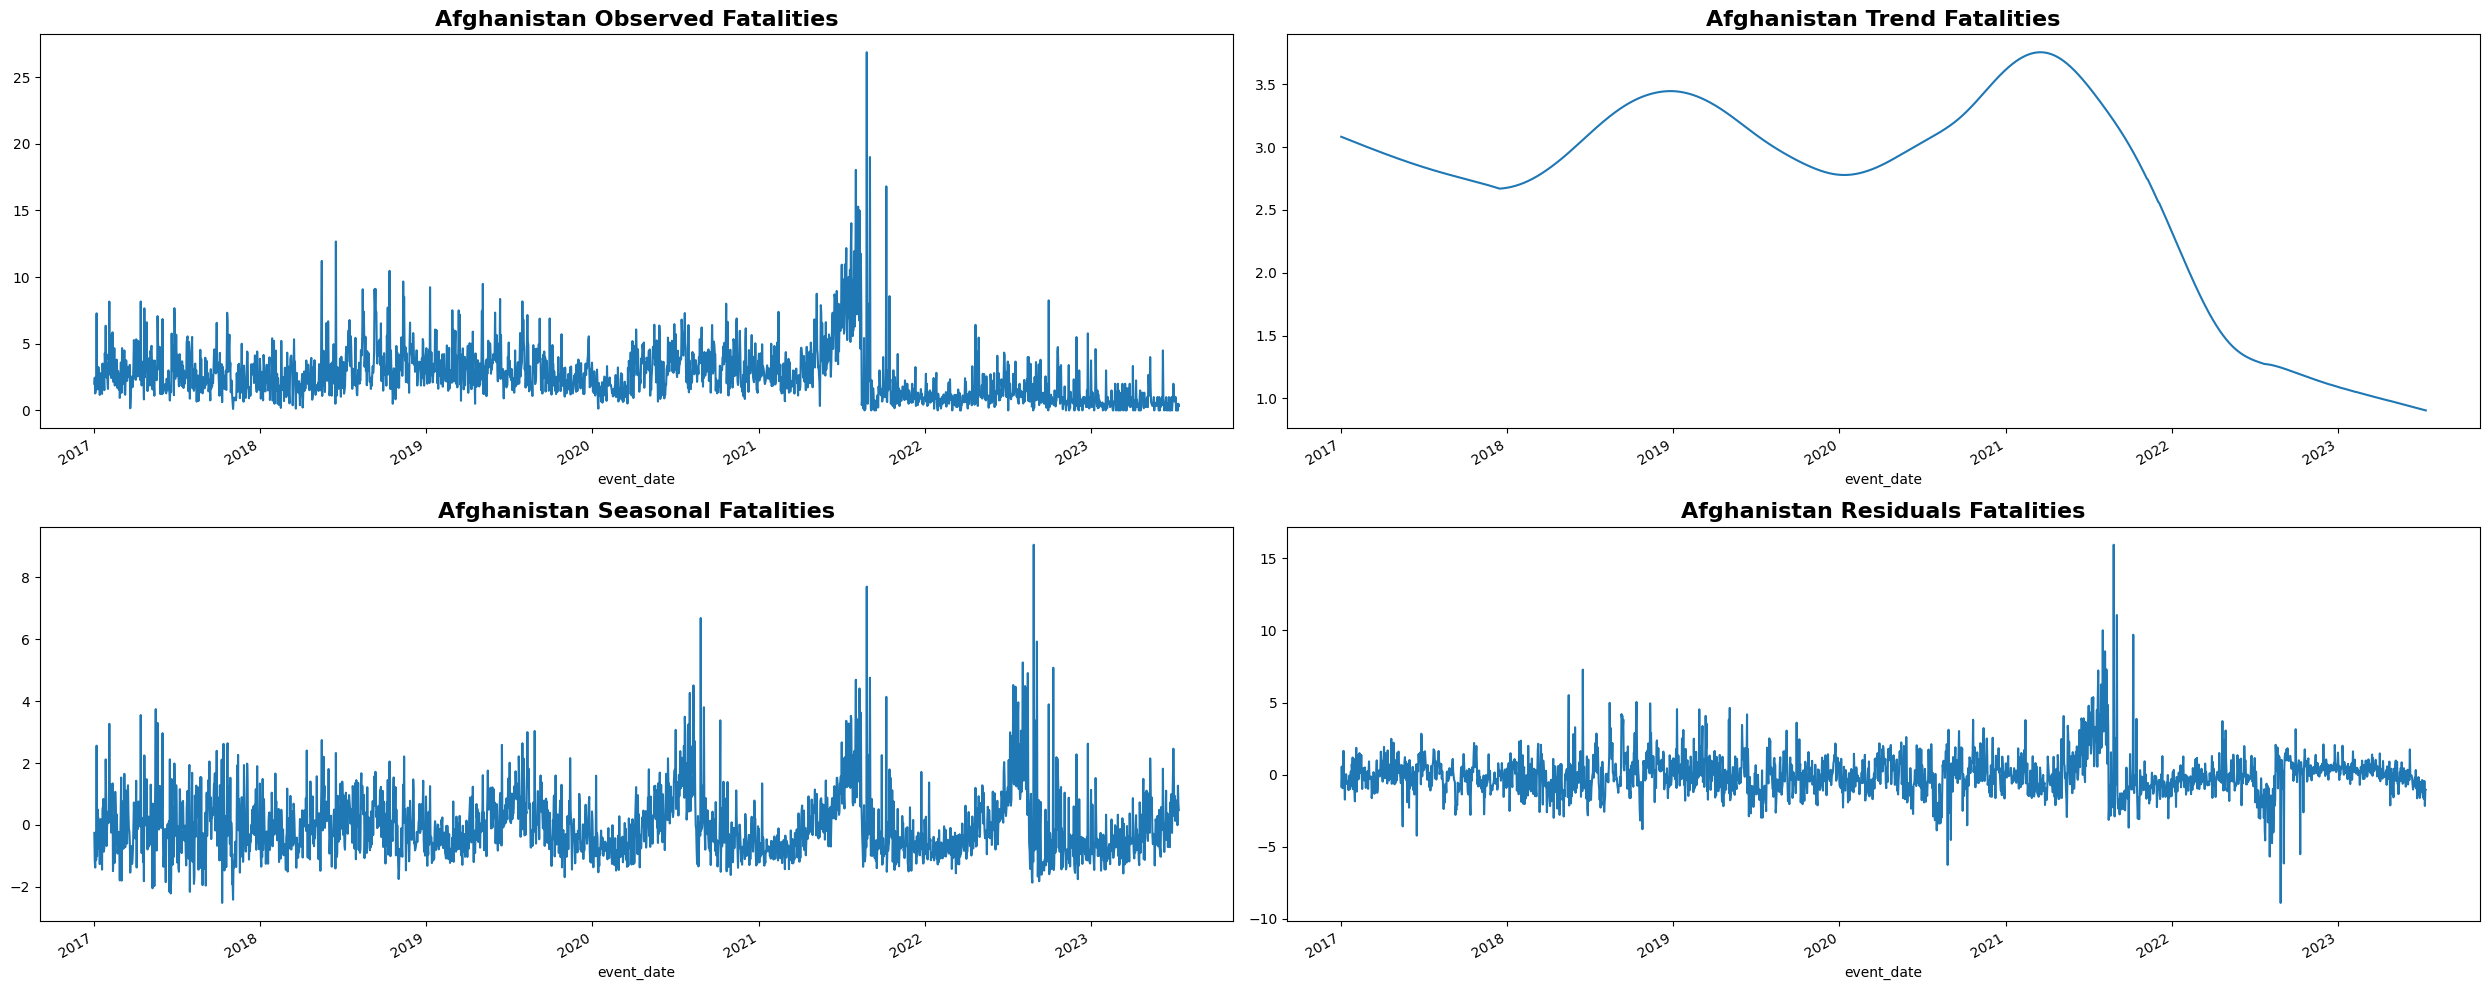

In [90]:
fatalities_stl: 'STL' = STL(afghan_df.groupby('event_date')['fatalities'].mean(), period=365).fit() # .plot() # mean overall fatalities
fig = plt.figure(figsize=(25, 10))

ax = fig.add_subplot(2,2,1)
fatalities_stl.observed.plot(ax=ax)
ax.set_title("Afghanistan Observed Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,2)
fatalities_stl.trend.plot(ax=ax)
ax.set_title("Afghanistan Trend Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,3)
fatalities_stl.seasonal.plot(ax=ax)
ax.set_title("Afghanistan Seasonal Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,4)
fatalities_stl.resid.plot(ax=ax)
ax.set_title("Afghanistan Residuals Fatalities", fontweight='bold', fontsize=16)

plt.tight_layout()